In [50]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [51]:
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [52]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [54]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [55]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [56]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)# remove punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)# remove URLs
    text = re.sub(r'\@\w+|\#','', text) # remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove numbers
    # lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [57]:
df['text'] = df['text'].apply(clean_data)

In [58]:
df.head()

,target,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri wkli comp win fa cup final tkt st m...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though


In [59]:
category_counts = df['target'].value_counts()
print(category_counts)

target
ham     4825
spam     747
Name: count, dtype: int64


In [60]:
mapper = {'ham': 0, 'spam': 1}
df['target'] = df['target'].map(mapper)
category_counts = df['target'].value_counts()
print(category_counts)

target
0    4825
1     747
Name: count, dtype: int64


In [61]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda text: len(word_tokenize(text)))
df['num_sentences'] = df['text'].apply(lambda text: len(sent_tokenize(text)))

In [62]:
vectorizer = TfidfVectorizer()

X_text = vectorizer.fit_transform(df['text'])
X_features = df[['num_characters', 'num_words', 'num_sentences']].values
X = np.hstack((X_text.toarray(), X_features))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2, random_state=42)

In [64]:
base_model = DecisionTreeClassifier(random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)

In [65]:
base_models = [
    ('dt', DecisionTreeClassifier(random_state=42)),  # Decision Tree
    ('knn', KNeighborsClassifier(n_neighbors=6)),                 # KNN
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),  # Random Forest   
    
    # ('svm', SVC(probability=True, kernel='linear', random_state=42))  # SVM
]

# Define the meta-learner (final model)
meta_learner = LogisticRegression()

# Create the Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,  # Base models
    final_estimator=meta_learner,  # Meta model
    passthrough=False,  # Use original features + predictions from base models
    cv=5  # Cross-validation
)

# Train the Stacking model on the training data
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=6)),
                               ('lr', LogisticRegression(max_iter=1000)),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [66]:
xgb_model = XGBClassifier(
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage (controls impact of each tree)
    max_depth=3,        # Maximum depth of each tree
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"  # Multi-class log loss
)

xgb_model.fit(X_train, y_train)

c:\Users\my\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:10:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [67]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model (Decision Tree)
    n_estimators=10,  # Number of estimators (trees)
    max_samples=0.8,  # Percentage of data used per model
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    random_state=42
)

bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  random_state=42)

In [68]:

y_pred_stacking = stacking_model.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_pred_stacking)


y_pred_xgb = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)


y_pred_bagging = bagging_model.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_pred_bagging)


# Print results


In [ ]:
print(f"📌 Accuracy of Decision Tree: {base_accuracy:.4f}")
print(f"✅ Accuracy of Bagging with 10 Trees: {bagging_accuracy:.4f}")
print(f"✅ Accuracy using XGBoost: {xgb_accuracy:.4f}")
print(f"✅ Accuracy of Stacking (DT, KNN, SVM + Logistic Regression): {stacking_accuracy:.4f}")


📌 Accuracy of Decision Tree: 0.9632
✅ Accuracy of Stacking (DT, KNN, SVM + Logistic Regression): 0.9812
✅ Accuracy using XGBoost: 0.9623
✅ Accuracy of Bagging with 10 Trees: 0.9713


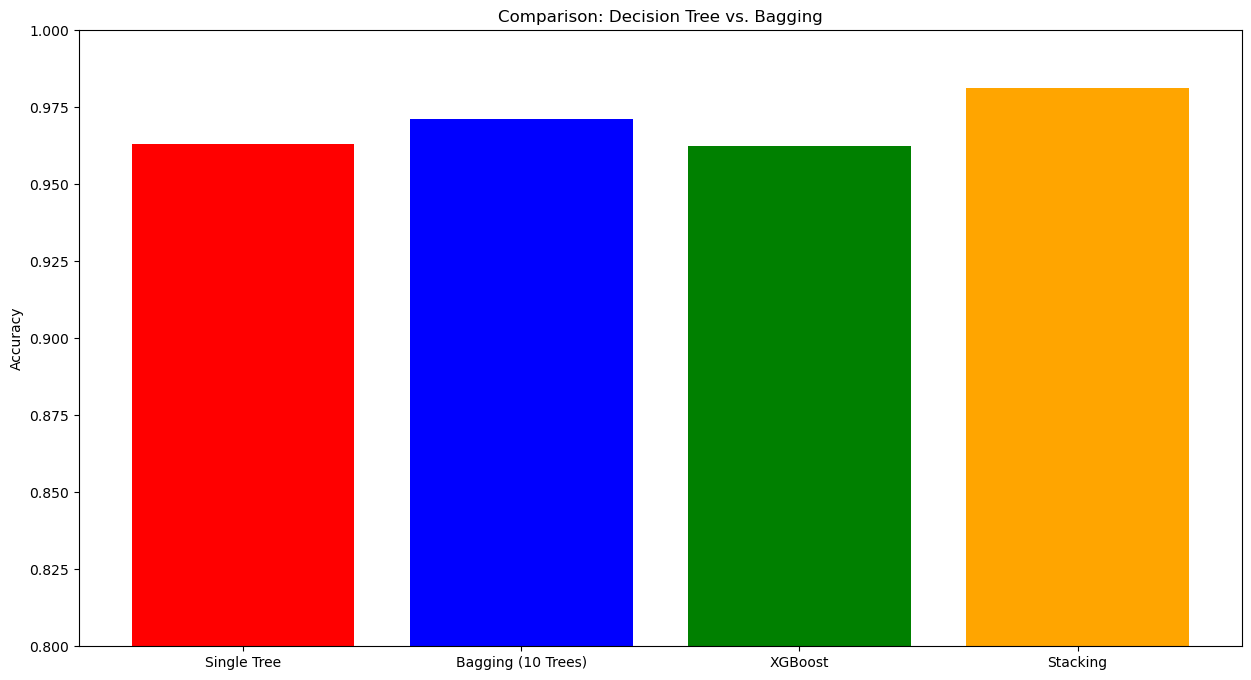

In [73]:
labels = ['Single Tree', 'Bagging (10 Trees)','XGBoost', 'Stacking']
accuracies = [base_accuracy, bagging_accuracy, xgb_accuracy, stacking_accuracy] 
plt.figure(figsize=(15, 8))
plt.bar(labels, accuracies, color=['red', 'blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison: Decision Tree vs. Bagging')
plt.ylim(0.8, 1)  # Adjust scale
plt.show()